# Project_07: Time Series Analysis

### Project goal: to create a short-term temperature forecast.

EUROPEAN CLIMATE ASSESSMENT & DATASET (ECA&D), available at http://www.ecad.eu
Daily dataset of 20th-century surface air temperature and precipitation series for the European Climate Assessment.

FILE FORMAT (MISSING VALUE CODE IS -9999):
- 01-06 SOUID: Source identifier
- 08-15 DATE : Date YYYYMMDD
- 17-21 TG   : mean temperature in 0.1 &#176;C
- 23-27 Q_TG : Quality code for TG (0='valid'; 1='suspect'; 9='missing')

This is the blended series of station GERMANY, BERLIN-TEMPELHOF (STAID: 2759).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)
import datetime

# machine learning stack - sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score

# statsmodels
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa import stattools
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults,ARMA,ARMAResults
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.stattools import adfuller, acf, pacf

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('TG_STAID002759.txt', skiprows=19)#skip first 19 rows with description
df.columns = df.columns.str.strip()# remove leading and trailing characters.

In [3]:
df.rename(columns={'SOUID': 'source', 'DATE': 'timestamp',
          'TG': "temp", 'Q_TG': 'QTG'}, inplace=True)

In [4]:
df.head()

,source,timestamp,temp,QTG
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53599 entries, 0 to 53598
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   source     53599 non-null  int64
 1   timestamp  53599 non-null  int64
 2   temp       53599 non-null  int64
 3   QTG        53599 non-null  int64
dtypes: int64(4)
memory usage: 1.6 MB


### Functions

In [6]:
# visualization
def plot_meantemp(df, title='Mean temperature in Berlin Templehof', ylim=True):
    df.plot()
    plt.title(title)
    plt.ylabel('temperature')
    if ylim:
        plt.ylim(ymin=-23)
    plt.show()

In [7]:
def print_adf(data):
    
    """Dickey Fuller Test"""
    
    adf_stats, p, used_lag, n_obs, levels, information_criterion = \
            statsmodels.tsa.stattools.adfuller(data)
    
    print(f"""   
            adf: {round(adf_stats,2)}
            p: {p} 
            used lag: {used_lag} 
            number of observations: {n_obs}
            {round(levels['1%'],2)} (p=0.01; CI=99%) 
            {round(levels['5%'],2)} (p=0.05; CI=95%)
            {round(levels['10%'],2)} (p=0.1 CI=90%) 
            information criterion (AIC): {information_criterion}
            """)

### Clean the data

In [8]:
df['timestamp']=df['timestamp'].astype(str) # convert to a string

In [9]:
# change to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [10]:
df['timestamp'].max()

Timestamp('2022-09-30 00:00:00')

In [11]:
# reset index
df = df.set_index('timestamp')
df.head()

,source,temp,QTG
timestamp,,,
1876-01-01,127488,22,0
1876-01-02,127488,25,0
1876-01-03,127488,3,0
1876-01-04,127488,-58,0
1876-01-05,127488,-98,0


In [12]:
# convert to a standard Celcius format
df['temp'] = df['temp'] * 0.1

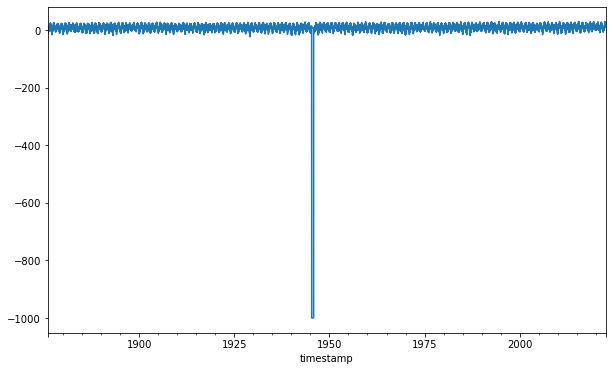

In [13]:
df['temp'].plot();

In [14]:
df[df['temp'] == -999.9000000000001]

,source,temp,QTG
timestamp,,,
1945-04-25,127488,-999.9,9
1945-04-26,127488,-999.9,9
1945-04-27,127488,-999.9,9
1945-04-28,127488,-999.9,9
1945-04-29,127488,-999.9,9
...,...,...,...
1945-11-01,127488,-999.9,9
1945-11-02,127488,-999.9,9
1945-11-03,127488,-999.9,9


In [15]:
strange_values = df[df['QTG'] == 9]# define the time period with missing values
strange_values

,source,temp,QTG
timestamp,,,
1945-04-25,127488,-999.9,9
1945-04-26,127488,-999.9,9
1945-04-27,127488,-999.9,9
1945-04-28,127488,-999.9,9
1945-04-29,127488,-999.9,9
...,...,...,...
1945-11-01,127488,-999.9,9
1945-11-02,127488,-999.9,9
1945-11-03,127488,-999.9,9


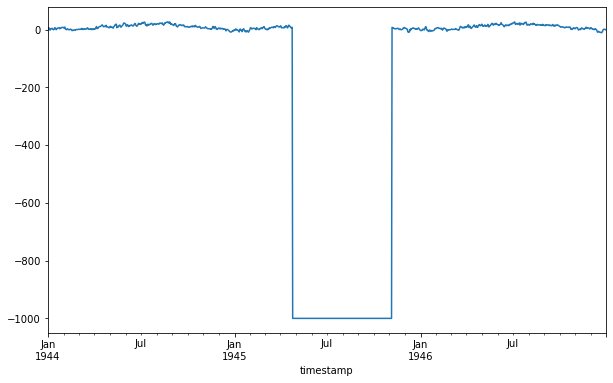

In [16]:
df['temp']['1944-01-01':'1946-12-31'].plot();# investigate the data of 3 years(one before and one after 1945)

In [17]:
year_1944 = df.loc['1944-04-25':'1944-11-05', 'temp']
year_1945 = df.loc['1945-04-25':'1945-11-05', 'temp']
year_1946 = df.loc['1946-04-25':'1946-11-05', 'temp']

replaced_temp = []
for day_temp in range(195):
    mean_temp = (year_1944.iloc[day_temp] + year_1946.iloc[day_temp]) / 2
    replaced_temp.append(mean_temp)

df.loc['1945-04-25':'1945-11-05', 'temp'] = replaced_temp

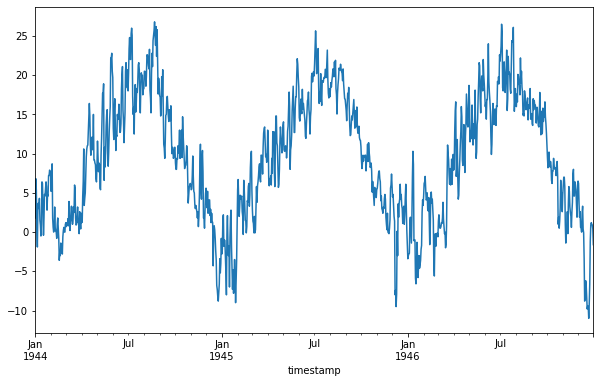

In [18]:
df['temp']['1944-01-01':'1946-12-31'].plot();

In [19]:
df = df.drop(['QTG', 'source'], axis=1)

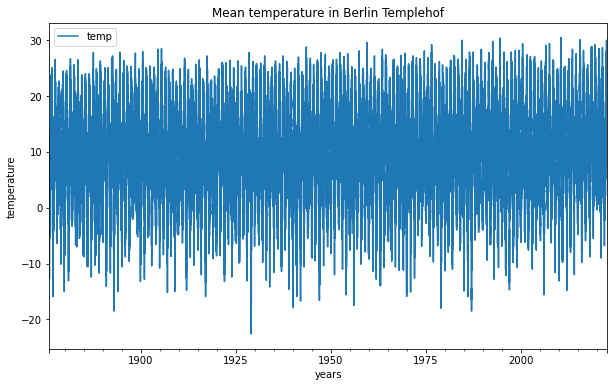

In [20]:
df.plot() 
plt.xlabel('years', fontsize=10)
plt.ylabel('temperature', fontsize=10)
plt.title('Mean temperature in Berlin Templehof');

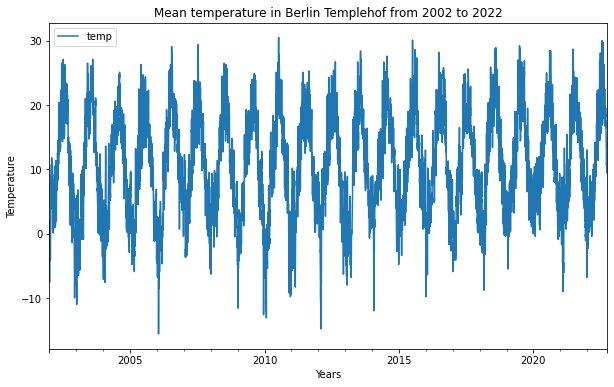

In [21]:
df.loc['2002':'2022'].plot()
plt.xlabel('Years', fontsize=10)
plt.ylabel('Temperature', fontsize=10)
plt.title('Mean temperature in Berlin Templehof from 2002 to 2022' );

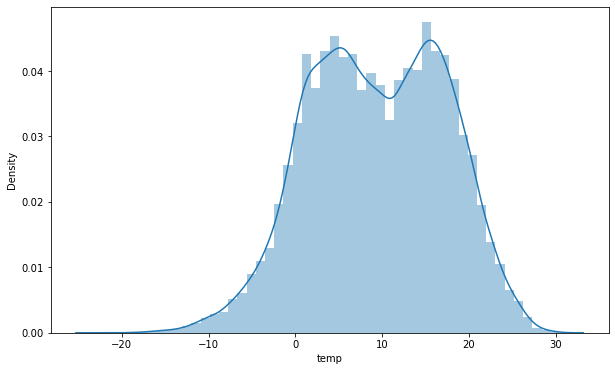

In [22]:
sns.distplot(df["temp"]);

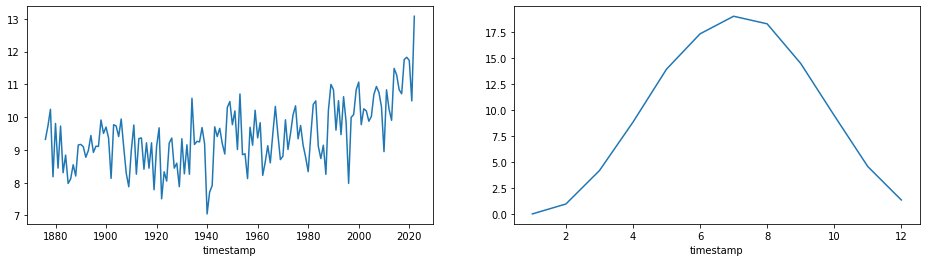

In [23]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(16, 4)
df.groupby(df.index.year)['temp'].mean().plot(ax=ax1)
df.groupby(df.index.month)['temp'].mean().plot(ax=ax2);

### Extract the timestep and the seasonal dummies for the whole dataset

In [24]:
df['timestep'] = list(range(len(df)))

In [25]:
df.head()

,temp,timestep
timestamp,,
1876-01-01,2.2,0
1876-01-02,2.5,1
1876-01-03,0.3,2
1876-01-04,-5.8,3
1876-01-05,-9.8,4


In [26]:
df['month'] = df.index.month
#df['year'] = df.index.year
df.head(2)

,temp,timestep,month
timestamp,,,
1876-01-01,2.2,0,1
1876-01-02,2.5,1,1


In [27]:
#df = df.astype({'month':'category'})
#sns.displot(
    #df, x="temp",col='month', col_wrap=4,
    #binwidth=1, height= 3, facet_kws=dict(margin_titles=True));

In [28]:
#seasonal_dummies = pd.get_dummies(df.index.month_name(), drop_first=True).set_index(df.index)
#seasonal_dummies

In [29]:
seasonal_dummies = pd.get_dummies(data=df['month'],
    prefix='month',
    drop_first=True).set_index(df.index)

seasonal_dummies

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
timestamp,,,,,,,,,,,
1876-01-01,0,0,0,0,0,0,0,0,0,0,0
1876-01-02,0,0,0,0,0,0,0,0,0,0,0
1876-01-03,0,0,0,0,0,0,0,0,0,0,0
1876-01-04,0,0,0,0,0,0,0,0,0,0,0
1876-01-05,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,0,0,0,0,0,0,0,1,0,0,0
2022-09-27,0,0,0,0,0,0,0,1,0,0,0
2022-09-28,0,0,0,0,0,0,0,1,0,0,0


In [30]:
df = df.join(seasonal_dummies)
df

,temp,timestep,month,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
timestamp,,,,,,,,,,,,,,
1876-01-01,2.2,0,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-02,2.5,1,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-03,0.3,2,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-04,-5.8,3,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-05,-9.8,4,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,13.6,53594,9,0,0,0,0,0,0,0,1,0,0,0
2022-09-27,11.2,53595,9,0,0,0,0,0,0,0,1,0,0,0
2022-09-28,9.4,53596,9,0,0,0,0,0,0,0,1,0,0,0


### Train-Test-Split

In [31]:
df_train = df[:-365] #everything but the last year, the last 365 days as training data
df_test = df[-365:] # take the last year to test

#### Trend

In [32]:
#X = df_train[['timestep']]
#y = df_train['temp']

In [33]:
#m_lr = LinearRegression()
#m_lr.fit(X,y)

In [34]:
#df_train['trend'] = m_lr.predict(X)
#df_train

In [35]:
#plot_meantemp(df=df_train[['temp','trend']]);

### Model the trend_seasonal model

In [36]:
X = df_train.drop(['temp', 'month'],axis=1) 
y = df_train['temp']

X

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
timestamp,,,,,,,,,,,,
1876-01-01,0,0,0,0,0,0,0,0,0,0,0,0
1876-01-02,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-03,2,0,0,0,0,0,0,0,0,0,0,0
1876-01-04,3,0,0,0,0,0,0,0,0,0,0,0
1876-01-05,4,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-26,53229,0,0,0,0,0,0,0,1,0,0,0
2021-09-27,53230,0,0,0,0,0,0,0,1,0,0,0
2021-09-28,53231,0,0,0,0,0,0,0,1,0,0,0


In [37]:
m_lr2 = LinearRegression()
m_lr2.fit(X,y)

LinearRegression()

In [38]:
# create a new column with the predictions of the seasonal_trend model
df_train['seasonal_trend'] = m_lr2.predict(X)
df_train.head(5)

,temp,timestep,month,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,seasonal_trend
timestamp,,,,,,,,,,,,,,,
1876-01-01,2.2,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.873310
1876-01-02,2.5,1,1,0,0,0,0,0,0,0,0,0,0,0,-0.873277
1876-01-03,0.3,2,1,0,0,0,0,0,0,0,0,0,0,0,-0.873245
1876-01-04,-5.8,3,1,0,0,0,0,0,0,0,0,0,0,0,-0.873212
1876-01-05,-9.8,4,1,0,0,0,0,0,0,0,0,0,0,0,-0.873179


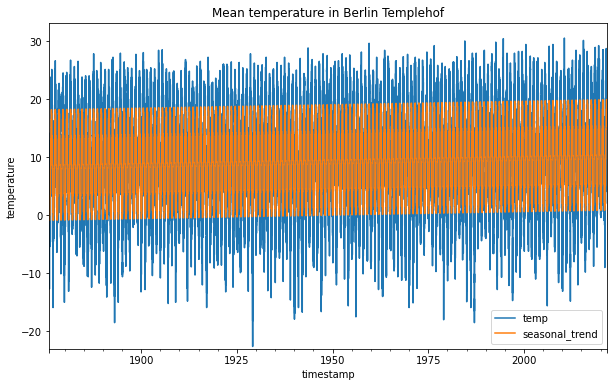

In [39]:
plot_meantemp(df_train[['temp','seasonal_trend']]);

### Extract the remainder

In [40]:
df_train['remainder'] = df_train['temp'] - df_train['seasonal_trend']

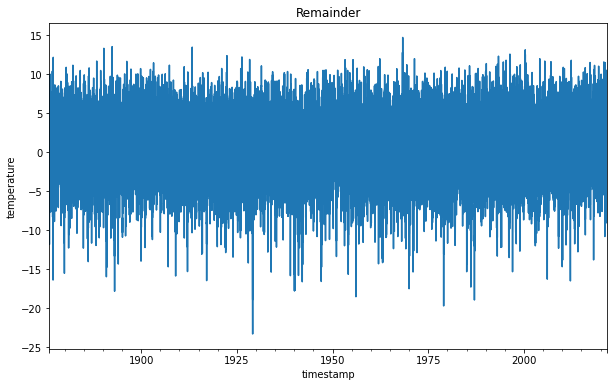

In [41]:
plot_meantemp(df_train['remainder'],title = "Remainder",ylim=False);

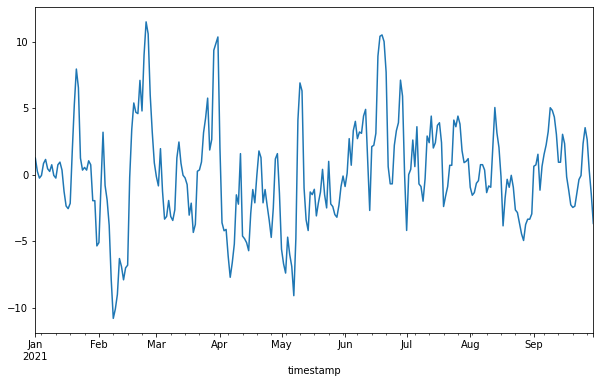

In [42]:
df_train[df_train.index.year==2021]['remainder'].plot();

In [43]:
print_adf(df_train['remainder'])

   
            adf: -23.8
            p: 0.0 
            used lag: 58 
            number of observations: 53175
            -3.43 (p=0.01; CI=99%) 
            -2.86 (p=0.05; CI=95%)
            -2.57 (p=0.1 CI=90%) 
            information criterion (AIC): 239757.8554999623
            


We rule out the H_0 that the time series is not stationary. The time series has no unit root.
    - adf of -23.8 is less than the value of the first value -3.430739767618574
    - p < 0.05(outside confidence interval)

In [44]:
df_train["remainder"].std(), df_train["temp"].std()

(3.925817705382548, 7.880821577557592)

In [45]:
df_train['remainder'].to_csv('df_train_remainder.csv')

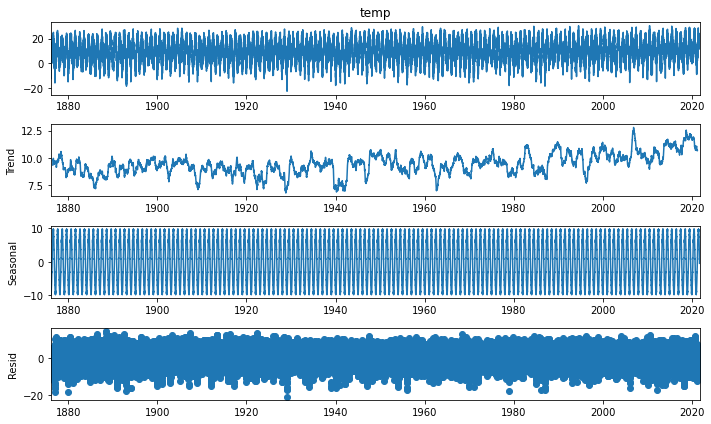

In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose
sd_diff = seasonal_decompose(df_train['temp'],model='additive',period=365)
p = sd_diff.plot()

### Inspect the remainder

In [47]:
df_train.head()

,temp,timestep,month,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,seasonal_trend,remainder
timestamp,,,,,,,,,,,,,,,,
1876-01-01,2.2,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.873310,3.073310
1876-01-02,2.5,1,1,0,0,0,0,0,0,0,0,0,0,0,-0.873277,3.373277
1876-01-03,0.3,2,1,0,0,0,0,0,0,0,0,0,0,0,-0.873245,1.173245
1876-01-04,-5.8,3,1,0,0,0,0,0,0,0,0,0,0,0,-0.873212,-4.926788
1876-01-05,-9.8,4,1,0,0,0,0,0,0,0,0,0,0,0,-0.873179,-8.926821


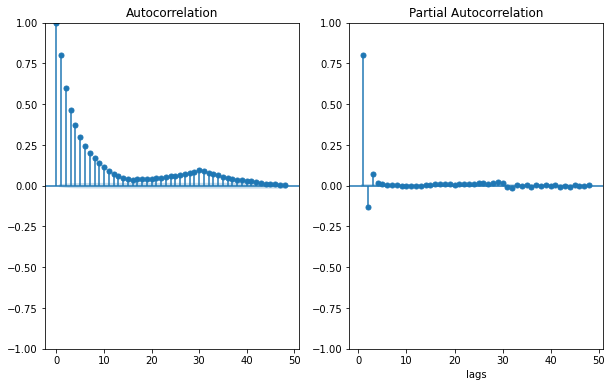

In [48]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(10, 6)
plot_acf(df_train['remainder'],ax=ax1)
plot_pacf(df_train['remainder'],zero=False, ax=ax2)
plt.xlabel('lags');

In [49]:
# Box-Jenkins-Methodology
selected_order = ar_select_order(df_train['remainder'], maxlag = 15)

In [50]:
print(f"The lags we need to include are {selected_order.ar_lags}")

The lags we need to include are [1, 2, 3, 4]


### time-lagged input features

In [51]:
df_train['lag1'] = df_train['remainder'].shift(1)
df_train['lag2'] = df_train['remainder'].shift(2)
df_train['lag3'] = df_train['remainder'].shift(3)
df_train['lag4'] = df_train['remainder'].shift(4)

In [52]:
df_train.head()

,temp,timestep,month,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,seasonal_trend,remainder,lag1,lag2,lag3,lag4
timestamp,,,,,,,,,,,,,,,,,,,,
1876-01-01,2.2,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.873310,3.073310,NaN,NaN,NaN,NaN
1876-01-02,2.5,1,1,0,0,0,0,0,0,0,0,0,0,0,-0.873277,3.373277,3.073310,NaN,NaN,NaN
1876-01-03,0.3,2,1,0,0,0,0,0,0,0,0,0,0,0,-0.873245,1.173245,3.373277,3.073310,NaN,NaN
1876-01-04,-5.8,3,1,0,0,0,0,0,0,0,0,0,0,0,-0.873212,-4.926788,1.173245,3.373277,3.073310,NaN
1876-01-05,-9.8,4,1,0,0,0,0,0,0,0,0,0,0,0,-0.873179,-8.926821,-4.926788,1.173245,3.373277,3.07331


In [53]:
df_train.dropna(inplace=True)
df_train.head()

,temp,timestep,month,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,seasonal_trend,remainder,lag1,lag2,lag3,lag4
timestamp,,,,,,,,,,,,,,,,,,,,
1876-01-05,-9.8,4,1,0,0,0,0,0,0,0,0,0,0,0,-0.873179,-8.926821,-4.926788,1.173245,3.373277,3.073310
1876-01-06,-7.7,5,1,0,0,0,0,0,0,0,0,0,0,0,-0.873146,-6.826854,-8.926821,-4.926788,1.173245,3.373277
1876-01-07,-6.6,6,1,0,0,0,0,0,0,0,0,0,0,0,-0.873114,-5.726886,-6.826854,-8.926821,-4.926788,1.173245
1876-01-08,-8.9,7,1,0,0,0,0,0,0,0,0,0,0,0,-0.873081,-8.026919,-5.726886,-6.826854,-8.926821,-4.926788
1876-01-09,-12.7,8,1,0,0,0,0,0,0,0,0,0,0,0,-0.873048,-11.826952,-8.026919,-5.726886,-6.826854,-8.926821


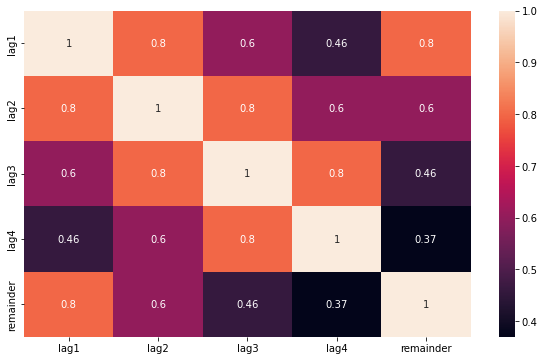

In [54]:
sns.heatmap(round(df_train[['lag1','lag2','lag3','lag4','remainder']].corr(), 2), annot=True);

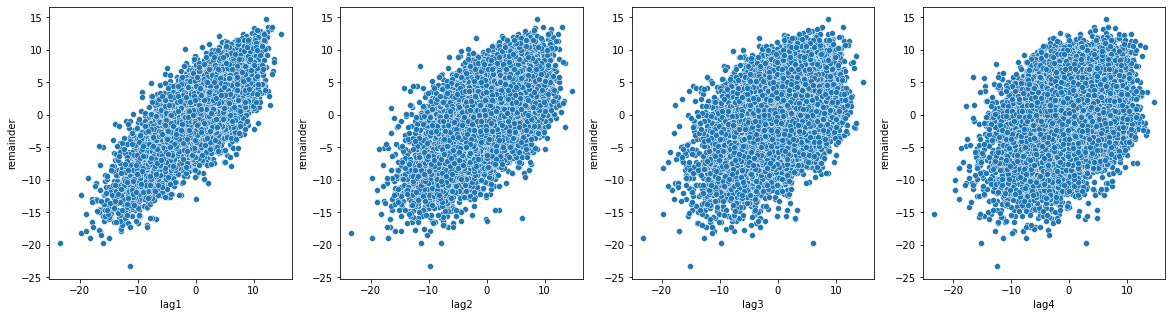

In [55]:
fig,(ax1,ax2,ax3, ax4) = plt.subplots(ncols=4)
fig.set_size_inches(20, 5)
sns.scatterplot(x='lag1', y='remainder', data=df_train,ax=ax1)
sns.scatterplot(x='lag2', y='remainder', data=df_train,ax=ax2)
sns.scatterplot(x='lag3', y='remainder', data=df_train,ax=ax3)
sns.scatterplot(x='lag4', y='remainder', data=df_train,ax=ax4);

In [56]:
df_train

,temp,timestep,month,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,seasonal_trend,remainder,lag1,lag2,lag3,lag4
timestamp,,,,,,,,,,,,,,,,,,,,
1876-01-05,-9.8,4,1,0,0,0,0,0,0,0,0,0,0,0,-0.873179,-8.926821,-4.926788,1.173245,3.373277,3.073310
1876-01-06,-7.7,5,1,0,0,0,0,0,0,0,0,0,0,0,-0.873146,-6.826854,-8.926821,-4.926788,1.173245,3.373277
1876-01-07,-6.6,6,1,0,0,0,0,0,0,0,0,0,0,0,-0.873114,-5.726886,-6.826854,-8.926821,-4.926788,1.173245
1876-01-08,-8.9,7,1,0,0,0,0,0,0,0,0,0,0,0,-0.873081,-8.026919,-5.726886,-6.826854,-8.926821,-4.926788
1876-01-09,-12.7,8,1,0,0,0,0,0,0,0,0,0,0,0,-0.873048,-11.826952,-8.026919,-5.726886,-6.826854,-8.926821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-26,18.9,53229,9,0,0,0,0,0,0,0,1,0,0,0,15.370776,3.529224,2.329257,-0.070710,-0.370678,-1.370645
2021-09-27,18.0,53230,9,0,0,0,0,0,0,0,1,0,0,0,15.370809,2.629191,3.529224,2.329257,-0.070710,-0.370678
2021-09-28,15.7,53231,9,0,0,0,0,0,0,0,1,0,0,0,15.370841,0.329159,2.629191,3.529224,2.329257,-0.070710


### Autoregression model

In [57]:
# AR model using stats model
ar_model = AutoReg(endog=df_train['remainder'], lags=4).fit()
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                53230
Model:                     AutoReg(4)   Log Likelihood             -120047.656
Method:               Conditional MLE   S.D. of innovations              2.308
Date:                Fri, 04 Nov 2022   AIC                         240107.311
Time:                        01:26:23   BIC                         240160.605
Sample:                    01-09-1876   HQIC                        240123.957
                         - 09-30-2021                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0002      0.010      0.017      0.986      -0.019       0.020
remainder.L1     0.9189      0.004    212.036      0.000       0.910       0.927
remainder.L2    -0.1932      0.006    -32.844      0.000      -0.205      -0.182
remainder.L3     0.0542      0.006      9.217      0.000       0.043       0.066
remainder.L4     0.0166      0.004      3.840      0.000       0.008       0.025
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2581           -0.0000j            1.2581           -0.0000
AR.2            1.0117           -2.5062j            2.7027           -0.1889
AR.3            1.0117           +2.5062j            2.7027            0.1889
AR.4           -6.5391           -0.0000j            6.5391           -0.5000
-----------------------------------------------------------------------------
"""

In [58]:
df_train['ar_prediction'] = ar_model.predict()
df_train

,temp,timestep,month,month_2,month_3,month_4,month_5,month_6,month_7,month_8,...,month_10,month_11,month_12,seasonal_trend,remainder,lag1,lag2,lag3,lag4,ar_prediction
timestamp,,,,,,,,,,,,,,,,,,,,,
1876-01-05,-9.8,4,1,0,0,0,0,0,0,0,...,0,0,0,-0.873179,-8.926821,-4.926788,1.173245,3.373277,3.073310,NaN
1876-01-06,-7.7,5,1,0,0,0,0,0,0,0,...,0,0,0,-0.873146,-6.826854,-8.926821,-4.926788,1.173245,3.373277,NaN
1876-01-07,-6.6,6,1,0,0,0,0,0,0,0,...,0,0,0,-0.873114,-5.726886,-6.826854,-8.926821,-4.926788,1.173245,NaN
1876-01-08,-8.9,7,1,0,0,0,0,0,0,0,...,0,0,0,-0.873081,-8.026919,-5.726886,-6.826854,-8.926821,-4.926788,NaN
1876-01-09,-12.7,8,1,0,0,0,0,0,0,0,...,0,0,0,-0.873048,-11.826952,-8.026919,-5.726886,-6.826854,-8.926821,-6.788354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-26,18.9,53229,9,0,0,0,0,0,0,0,...,0,0,0,15.370776,3.529224,2.329257,-0.070710,-0.370678,-1.370645,2.111349
2021-09-27,18.0,53230,9,0,0,0,0,0,0,0,...,0,0,0,15.370809,2.629191,3.529224,2.329257,-0.070710,-0.370678,2.783335
2021-09-28,15.7,53231,9,0,0,0,0,0,0,0,...,0,0,0,15.370841,0.329159,2.629191,3.529224,2.329257,-0.070710,1.859561


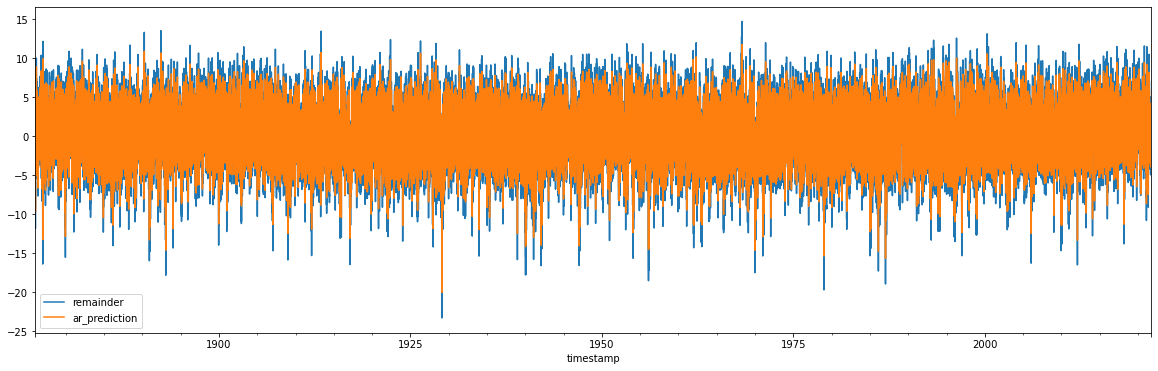

In [59]:
df_train[['remainder', 'ar_prediction']].plot(figsize = (20, 6));

In [60]:
df_train.dropna(inplace = True)

### Full AR Model with lag features and seasonal trend

In [61]:
df_train['full_pred_ar'] = df_train['seasonal_trend'] + df_train['ar_prediction']
df_train.head()

,temp,timestep,month,month_2,month_3,month_4,month_5,month_6,month_7,month_8,...,month_11,month_12,seasonal_trend,remainder,lag1,lag2,lag3,lag4,ar_prediction,full_pred_ar
timestamp,,,,,,,,,,,,,,,,,,,,,
1876-01-09,-12.7,8,1,0,0,0,0,0,0,0,...,0,0,-0.873048,-11.826952,-8.026919,-5.726886,-6.826854,-8.926821,-6.788354,-7.661402
1876-01-10,-8.9,9,1,0,0,0,0,0,0,0,...,0,0,-0.873015,-8.026985,-11.826952,-8.026919,-5.726886,-6.826854,-9.741447,-10.614462
1876-01-11,-6.2,10,1,0,0,0,0,0,0,0,...,0,0,-0.872983,-5.327017,-8.026985,-11.826952,-8.026919,-5.726886,-5.621874,-6.494856
1876-01-12,-4.6,11,1,0,0,0,0,0,0,0,...,0,0,-0.872950,-3.727050,-5.327017,-8.026985,-11.826952,-8.026919,-4.119098,-4.992048
1876-01-13,-3.5,12,1,0,0,0,0,0,0,0,...,0,0,-0.872917,-2.627083,-3.727050,-5.327017,-8.026985,-11.826952,-3.027639,-3.900556


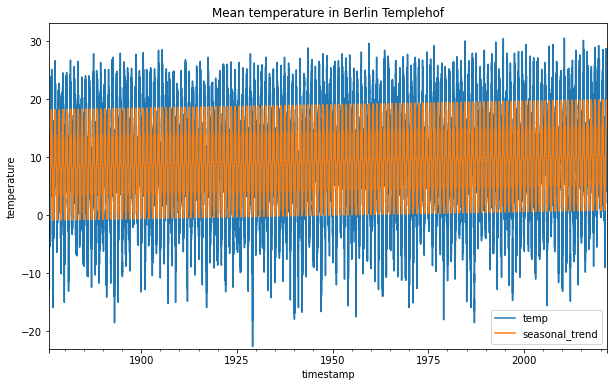

In [62]:
plot_meantemp(df_train[['temp', 'seasonal_trend']])

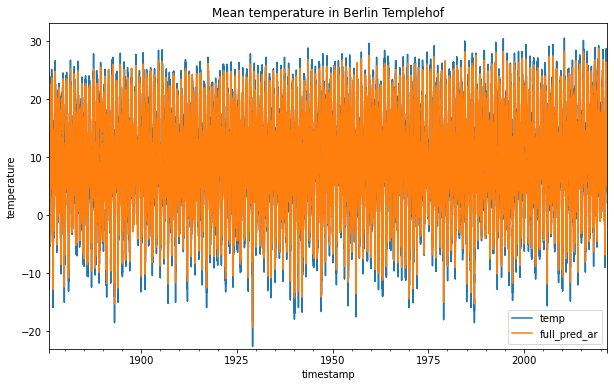

In [63]:
plot_meantemp(df_train[['temp', 'full_pred_ar']])

### ARIMA

In [64]:
from statsmodels.tsa.arima.model import ARIMA

In [65]:
arima = ARIMA(endog= df_train['remainder'], order = (1,0,1)).fit()

In [66]:
df_train['arima_prediction'] = arima.predict()
df_train.head()

,temp,timestep,month,month_2,month_3,month_4,month_5,month_6,month_7,month_8,...,month_12,seasonal_trend,remainder,lag1,lag2,lag3,lag4,ar_prediction,full_pred_ar,arima_prediction
timestamp,,,,,,,,,,,,,,,,,,,,,
1876-01-09,-12.7,8,1,0,0,0,0,0,0,0,...,0,-0.873048,-11.826952,-8.026919,-5.726886,-6.826854,-8.926821,-6.788354,-7.661402,0.000360
1876-01-10,-8.9,9,1,0,0,0,0,0,0,0,...,0,-0.873015,-8.026985,-11.826952,-8.026919,-5.726886,-6.826854,-9.741447,-10.614462,-9.502411
1876-01-11,-6.2,10,1,0,0,0,0,0,0,0,...,0,-0.872983,-5.327017,-8.026985,-11.826952,-8.026919,-5.726886,-5.621874,-6.494856,-5.660846
1876-01-12,-4.6,11,1,0,0,0,0,0,0,0,...,0,-0.872950,-3.727050,-5.327017,-8.026985,-11.826952,-8.026919,-4.119098,-4.992048,-3.873144
1876-01-13,-3.5,12,1,0,0,0,0,0,0,0,...,0,-0.872917,-2.627083,-3.727050,-5.327017,-8.026985,-11.826952,-3.027639,-3.900556,-2.726110


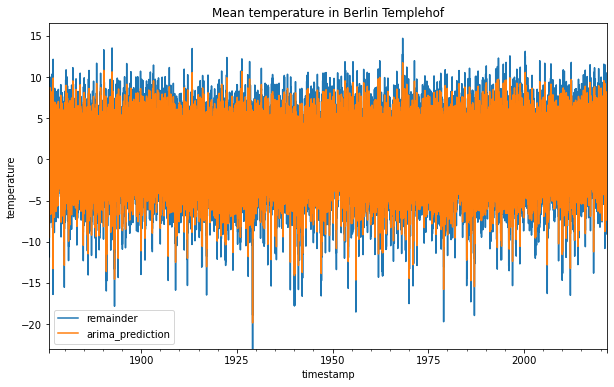

In [67]:
plot_meantemp(df_train[['remainder', 'arima_prediction']])

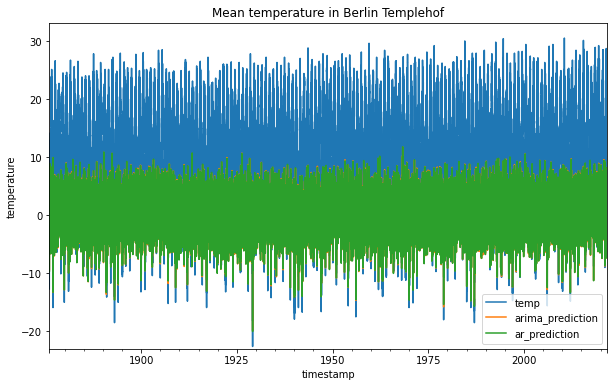

In [68]:
plot_meantemp(df_train[['temp', 'arima_prediction','ar_prediction']])

In [69]:
print("R2 score ARIMA Model: ",r2_score(df_train['remainder'], df_train['arima_prediction']))
print("MSE ARIMA Model: ", mean_squared_error(df_train['remainder'], df_train['arima_prediction']))
print("R2 score Autoregressive Model: ",r2_score(df_train['remainder'], df_train['ar_prediction']))
print("MSE Autoregressive Model: ", mean_squared_error(df_train['remainder'], df_train['ar_prediction']))

R2 score ARIMA Model:  0.6532472924384021
MSE ARIMA Model:  5.34311200799201
R2 score Autoregressive Model:  0.6542237980138125
MSE Autoregressive Model:  5.328065034883894


In [70]:
df_train

,temp,timestep,month,month_2,month_3,month_4,month_5,month_6,month_7,month_8,...,month_12,seasonal_trend,remainder,lag1,lag2,lag3,lag4,ar_prediction,full_pred_ar,arima_prediction
timestamp,,,,,,,,,,,,,,,,,,,,,
1876-01-09,-12.7,8,1,0,0,0,0,0,0,0,...,0,-0.873048,-11.826952,-8.026919,-5.726886,-6.826854,-8.926821,-6.788354,-7.661402,0.000360
1876-01-10,-8.9,9,1,0,0,0,0,0,0,0,...,0,-0.873015,-8.026985,-11.826952,-8.026919,-5.726886,-6.826854,-9.741447,-10.614462,-9.502411
1876-01-11,-6.2,10,1,0,0,0,0,0,0,0,...,0,-0.872983,-5.327017,-8.026985,-11.826952,-8.026919,-5.726886,-5.621874,-6.494856,-5.660846
1876-01-12,-4.6,11,1,0,0,0,0,0,0,0,...,0,-0.872950,-3.727050,-5.327017,-8.026985,-11.826952,-8.026919,-4.119098,-4.992048,-3.873144
1876-01-13,-3.5,12,1,0,0,0,0,0,0,0,...,0,-0.872917,-2.627083,-3.727050,-5.327017,-8.026985,-11.826952,-3.027639,-3.900556,-2.726110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-26,18.9,53229,9,0,0,0,0,0,0,0,...,0,15.370776,3.529224,2.329257,-0.070710,-0.370678,-1.370645,2.111349,17.482125,2.161887
2021-09-27,18.0,53230,9,0,0,0,0,0,0,0,...,0,15.370809,2.629191,3.529224,2.329257,-0.070710,-0.370678,2.783335,18.154143,2.862603
2021-09-28,15.7,53231,9,0,0,0,0,0,0,0,...,0,15.370841,0.329159,2.629191,3.529224,2.329257,-0.070710,1.859561,17.230402,1.898925


### Full model

In [71]:
# define X and y
X_full = df_train.drop(columns=['temp','seasonal_trend', 'remainder', 'ar_prediction', 'full_pred_ar', 'arima_prediction'])
y_full = df_train['temp']

In [72]:
# train the model
m_full = LinearRegression()
m_full.fit(X_full, y_full)

# new AR_prediction
df_train['full_model_pred'] = m_full.predict(X_full)
df_train

,temp,timestep,month,month_2,month_3,month_4,month_5,month_6,month_7,month_8,...,seasonal_trend,remainder,lag1,lag2,lag3,lag4,ar_prediction,full_pred_ar,arima_prediction,full_model_pred
timestamp,,,,,,,,,,,,,,,,,,,,,
1876-01-09,-12.7,8,1,0,0,0,0,0,0,0,...,-0.873048,-11.826952,-8.026919,-5.726886,-6.826854,-8.926821,-6.788354,-7.661402,0.000360,-7.632276
1876-01-10,-8.9,9,1,0,0,0,0,0,0,0,...,-0.873015,-8.026985,-11.826952,-8.026919,-5.726886,-6.826854,-9.741447,-10.614462,-9.502411,-10.584756
1876-01-11,-6.2,10,1,0,0,0,0,0,0,0,...,-0.872983,-5.327017,-8.026985,-11.826952,-8.026919,-5.726886,-5.621874,-6.494856,-5.660846,-6.465384
1876-01-12,-4.6,11,1,0,0,0,0,0,0,0,...,-0.872950,-3.727050,-5.327017,-8.026985,-11.826952,-8.026919,-4.119098,-4.992048,-3.873144,-4.962997
1876-01-13,-3.5,12,1,0,0,0,0,0,0,0,...,-0.872917,-2.627083,-3.727050,-5.327017,-8.026985,-11.826952,-3.027639,-3.900556,-2.726110,-3.872317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-26,18.9,53229,9,0,0,0,0,0,0,0,...,15.370776,3.529224,2.329257,-0.070710,-0.370678,-1.370645,2.111349,17.482125,2.161887,17.468449
2021-09-27,18.0,53230,9,0,0,0,0,0,0,0,...,15.370809,2.629191,3.529224,2.329257,-0.070710,-0.370678,2.783335,18.154143,2.862603,18.140714
2021-09-28,15.7,53231,9,0,0,0,0,0,0,0,...,15.370841,0.329159,2.629191,3.529224,2.329257,-0.070710,1.859561,17.230402,1.898925,17.217137


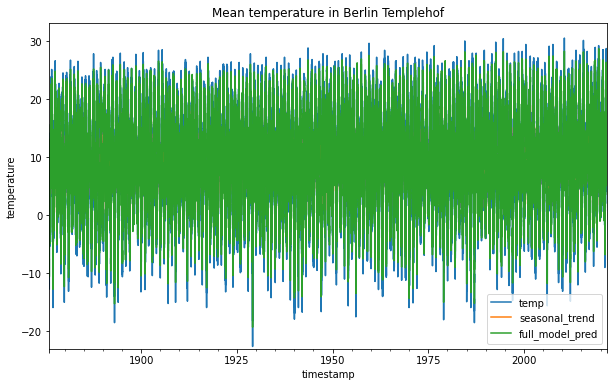

In [73]:
plot_meantemp(df_train[['temp','seasonal_trend','full_model_pred']]);

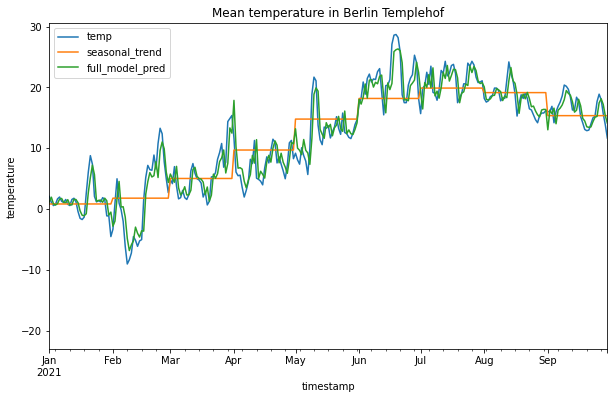

In [74]:
plot_meantemp(df_train[df_train.index.year==2021][['temp','seasonal_trend','full_model_pred']])

In [75]:
m_full.coef_

array([ 3.27061666e-05,  1.34156838e+00, -3.84577532e-01,  1.50266374e+00,
        4.80182341e+00,  8.54149171e+00,  1.05553851e+01,  1.09388204e+01,
        8.81486006e+00,  3.72679082e+00, -2.63317693e+00, -8.85565883e+00,
       -1.34112394e+01,  9.18854195e-01, -1.93114122e-01,  5.41947399e-02,
        1.68488117e-02])

In [76]:
#print("R2 score Seasonal_trend Model: ",r2_score(df_train['temp'], df_train['seasonal_trend']))
#print("MSE Seasonal_trend Model: ", mean_squared_error(df_train['temp'], df_train['seasonal_trend']))
print("R2 score Full Model: ",r2_score(df_train['temp'], df_train['full_model_pred']))
print("MSE Full Model: ", mean_squared_error(df_train['temp'], df_train['full_model_pred']))

R2 score Full Model:  0.9141910993742305
MSE Full Model:  5.327371356192906


#### Evaluation

In [77]:
# create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=10)

In [78]:
# Split the training data into folds
for i, (train_index, validation_index) in enumerate(ts_split.split(X_full, y_full)):
    print(f"""The training data for the {i+1}th iteration are the observations steps 
    {train_index}""")
    print(f"""The validation data for the {i+1}th iteration are the observations steps
    {validation_index}""")
    print('\n')

The training data for the 1th iteration are the observations steps 
    [   0    1    2 ... 4843 4844 4845]
The validation data for the 1th iteration are the observations steps
    [4846 4847 4848 ... 9681 9682 9683]


The training data for the 2th iteration are the observations steps 
    [   0    1    2 ... 9681 9682 9683]
The validation data for the 2th iteration are the observations steps
    [ 9684  9685  9686 ... 14519 14520 14521]


The training data for the 3th iteration are the observations steps 
    [    0     1     2 ... 14519 14520 14521]
The validation data for the 3th iteration are the observations steps
    [14522 14523 14524 ... 19357 19358 19359]


The training data for the 4th iteration are the observations steps 
    [    0     1     2 ... 19357 19358 19359]
The validation data for the 4th iteration are the observations steps
    [19360 19361 19362 ... 24195 24196 24197]


The training data for the 5th iteration are the observations steps 
    [    0     1     2 ...

In [79]:
# create the time series split
time_series_split = ts_split.split(X_full, y_full) 

In [80]:
# cross validation
result = cross_val_score(estimator=m_full, 
                         X=X_full, y=y_full,
                         cv=time_series_split)
result

array([0.91922615, 0.90683383, 0.89533269, 0.9150291 , 0.91599598,
       0.91136833, 0.91373769, 0.90458251, 0.9179825 , 0.92081667])

In [81]:
result.mean()

0.9120905447657224

### Test the model

In [82]:
df_test.head()

,temp,timestep,month,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
timestamp,,,,,,,,,,,,,,
2021-10-01,12.7,53234,10,0,0,0,0,0,0,0,0,1,0,0
2021-10-02,14.8,53235,10,0,0,0,0,0,0,0,0,1,0,0
2021-10-03,18.1,53236,10,0,0,0,0,0,0,0,0,1,0,0
2021-10-04,14.8,53237,10,0,0,0,0,0,0,0,0,1,0,0
2021-10-05,13.1,53238,10,0,0,0,0,0,0,0,0,1,0,0


In [83]:
# get last timestep of the training data
last_train_timestep = df_train['timestep'][-1]
last_train_timestep

53233

In [84]:
# create a timestep for the test data
df_test['timestep'] = list(range(last_train_timestep + 1, 
                            last_train_timestep + len(df_test) + 1))
df_test.head()

,temp,timestep,month,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
timestamp,,,,,,,,,,,,,,
2021-10-01,12.7,53234,10,0,0,0,0,0,0,0,0,1,0,0
2021-10-02,14.8,53235,10,0,0,0,0,0,0,0,0,1,0,0
2021-10-03,18.1,53236,10,0,0,0,0,0,0,0,0,1,0,0
2021-10-04,14.8,53237,10,0,0,0,0,0,0,0,0,1,0,0
2021-10-05,13.1,53238,10,0,0,0,0,0,0,0,0,1,0,0


#### Model test data

In [85]:
X_test = df_test.drop(columns=['temp', 'month'])
X_test

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
timestamp,,,,,,,,,,,,
2021-10-01,53234,0,0,0,0,0,0,0,0,1,0,0
2021-10-02,53235,0,0,0,0,0,0,0,0,1,0,0
2021-10-03,53236,0,0,0,0,0,0,0,0,1,0,0
2021-10-04,53237,0,0,0,0,0,0,0,0,1,0,0
2021-10-05,53238,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,53594,0,0,0,0,0,0,0,1,0,0,0
2022-09-27,53595,0,0,0,0,0,0,0,1,0,0,0
2022-09-28,53596,0,0,0,0,0,0,0,1,0,0,0


In [86]:
df_test['seasonal_trend'] = m_lr2.predict(X_test)
df_test.head()

,temp,timestep,month,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,seasonal_trend
timestamp,,,,,,,,,,,,,,,
2021-10-01,12.7,53234,10,0,0,0,0,0,0,0,0,1,0,0,10.354001
2021-10-02,14.8,53235,10,0,0,0,0,0,0,0,0,1,0,0,10.354033
2021-10-03,18.1,53236,10,0,0,0,0,0,0,0,0,1,0,0,10.354066
2021-10-04,14.8,53237,10,0,0,0,0,0,0,0,0,1,0,0,10.354099
2021-10-05,13.1,53238,10,0,0,0,0,0,0,0,0,1,0,0,10.354132


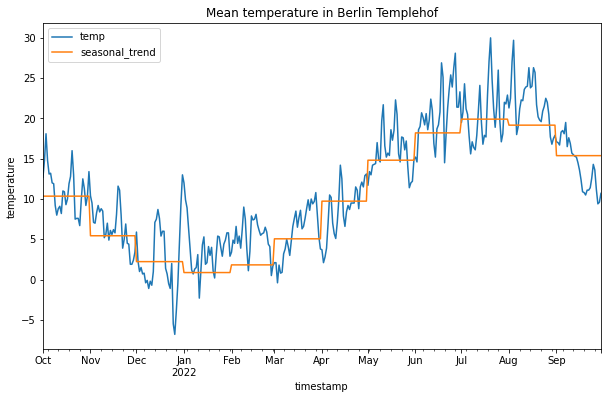

In [87]:
plot_meantemp(df_test[['temp', 'seasonal_trend']], ylim=False)

#### Calculate the remainder for the test data

In [88]:
df_test['remainder'] = df_test['temp'] - df_test['seasonal_trend']

In [89]:
df_test['lag1'] = df_test['remainder'].shift(1)
df_test['lag2'] = df_test['remainder'].shift(2)
df_test['lag3'] = df_test['remainder'].shift(3)
df_test['lag4'] = df_test['remainder'].shift(4)

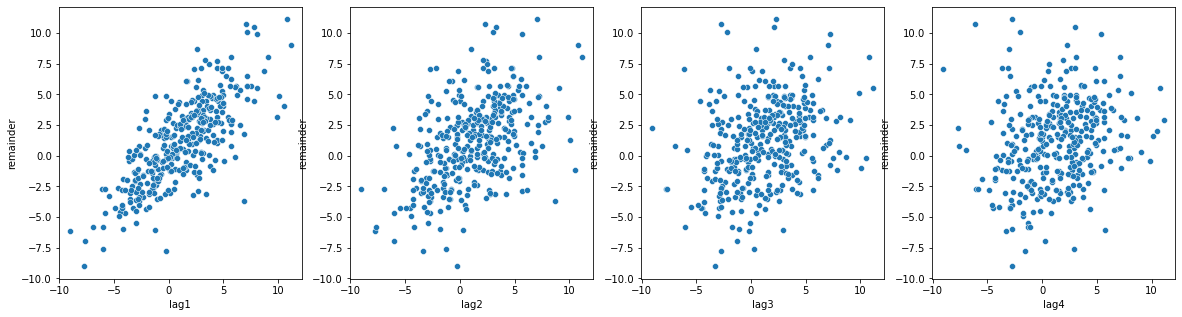

In [90]:
fig,(ax1,ax2,ax3, ax4) = plt.subplots(ncols=4)
fig.set_size_inches(20, 5)
sns.scatterplot(x='lag1', y='remainder', data=df_test,ax=ax1)
sns.scatterplot(x='lag2', y='remainder', data=df_test,ax=ax2)
sns.scatterplot(x='lag3', y='remainder', data=df_test,ax=ax3)
sns.scatterplot(x='lag4', y='remainder', data=df_test,ax=ax4);

In [91]:
df_test.head()

,temp,timestep,month,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,seasonal_trend,remainder,lag1,lag2,lag3,lag4
timestamp,,,,,,,,,,,,,,,,,,,,
2021-10-01,12.7,53234,10,0,0,0,0,0,0,0,0,1,0,0,10.354001,2.345999,NaN,NaN,NaN,NaN
2021-10-02,14.8,53235,10,0,0,0,0,0,0,0,0,1,0,0,10.354033,4.445967,2.345999,NaN,NaN,NaN
2021-10-03,18.1,53236,10,0,0,0,0,0,0,0,0,1,0,0,10.354066,7.745934,4.445967,2.345999,NaN,NaN
2021-10-04,14.8,53237,10,0,0,0,0,0,0,0,0,1,0,0,10.354099,4.445901,7.745934,4.445967,2.345999,NaN
2021-10-05,13.1,53238,10,0,0,0,0,0,0,0,0,1,0,0,10.354132,2.745868,4.445901,7.745934,4.445967,2.345999


In [92]:
# assign X_full
X_full = df_test.drop(columns=['temp', 'seasonal_trend', 'remainder'])

In [93]:
X_full.head()

,timestep,month,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4
timestamp,,,,,,,,,,,,,,,,,
2021-10-01,53234,10,0,0,0,0,0,0,0,0,1,0,0,NaN,NaN,NaN,NaN
2021-10-02,53235,10,0,0,0,0,0,0,0,0,1,0,0,2.345999,NaN,NaN,NaN
2021-10-03,53236,10,0,0,0,0,0,0,0,0,1,0,0,4.445967,2.345999,NaN,NaN
2021-10-04,53237,10,0,0,0,0,0,0,0,0,1,0,0,7.745934,4.445967,2.345999,NaN
2021-10-05,53238,10,0,0,0,0,0,0,0,0,1,0,0,4.445901,7.745934,4.445967,2.345999


In [94]:
X_full.loc['2021-10-01', 'lag1'] = df_train.loc['2021-09-30', 'remainder']
X_full.loc['2021-10-01', 'lag2'] = df_train.loc['2021-09-29', 'remainder'] 
X_full.loc['2021-10-01', 'lag3'] = df_train.loc['2021-09-28', 'remainder'] 
X_full.loc['2021-10-01', 'lag4'] = df_train.loc['2021-09-27', 'remainder']

In [95]:
X_full.loc['2021-10-02', 'lag2'] = X_full.loc['2021-10-01', 'lag1'] 
X_full.loc['2021-10-02', 'lag3'] = X_full.loc['2021-10-01', 'lag2'] 
X_full.loc['2021-10-02', 'lag4'] = X_full.loc['2021-10-01', 'lag3'] 
X_full.loc['2021-10-03', 'lag3'] = X_full.loc['2021-10-02', 'lag2'] 
X_full.loc['2021-10-03', 'lag4'] = X_full.loc['2021-10-02', 'lag3'] 
X_full.loc['2021-10-04', 'lag4'] = X_full.loc['2021-10-01', 'lag1'] 

In [96]:
X_full.head()

,timestep,month,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4
timestamp,,,,,,,,,,,,,,,,,
2021-10-01,53234,10,0,0,0,0,0,0,0,0,1,0,0,-3.670907,-1.470874,0.329159,2.629191
2021-10-02,53235,10,0,0,0,0,0,0,0,0,1,0,0,2.345999,-3.670907,-1.470874,0.329159
2021-10-03,53236,10,0,0,0,0,0,0,0,0,1,0,0,4.445967,2.345999,-3.670907,-1.470874
2021-10-04,53237,10,0,0,0,0,0,0,0,0,1,0,0,7.745934,4.445967,2.345999,-3.670907
2021-10-05,53238,10,0,0,0,0,0,0,0,0,1,0,0,4.445901,7.745934,4.445967,2.345999


### Full model test data

In [97]:
# new full model prediction
df_test['full_model_pred'] = m_full.predict(X_full)
df_test

,temp,timestep,month,month_2,month_3,month_4,month_5,month_6,month_7,month_8,...,month_10,month_11,month_12,seasonal_trend,remainder,lag1,lag2,lag3,lag4,full_model_pred
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-10-01,12.7,53234,10,0,0,0,0,0,0,0,...,1,0,0,10.354001,2.345999,NaN,NaN,NaN,NaN,7.312649
2021-10-02,14.8,53235,10,0,0,0,0,0,0,0,...,1,0,0,10.354033,4.445967,2.345999,NaN,NaN,NaN,13.129893
2021-10-03,18.1,53236,10,0,0,0,0,0,0,0,...,1,0,0,10.354066,7.745934,4.445967,2.345999,NaN,NaN,13.747982
2021-10-04,14.8,53237,10,0,0,0,0,0,0,0,...,1,0,0,10.354099,4.445901,7.745934,4.445967,2.345999,NaN,16.663686
2021-10-05,13.1,53238,10,0,0,0,0,0,0,0,...,1,0,0,10.354132,2.745868,4.445901,7.745934,4.445967,2.345999,13.209385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,13.6,53594,9,0,0,0,0,0,0,0,...,0,0,0,15.382723,-1.782723,-1.082690,-2.782658,-3.982625,-4.282592,14.624209
2022-09-27,11.2,53595,9,0,0,0,0,0,0,0,...,0,0,0,15.382756,-4.182756,-1.782723,-1.082690,-2.782658,-3.982625,13.722812
2022-09-28,9.4,53596,9,0,0,0,0,0,0,0,...,0,0,0,15.382788,-5.982788,-4.182756,-1.782723,-1.082690,-2.782658,11.765098


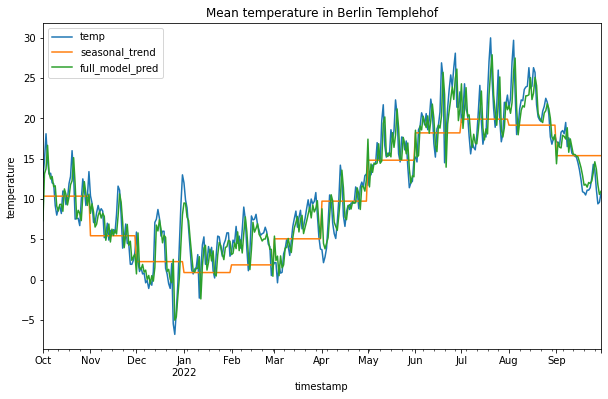

In [98]:
plot_meantemp(df_test[['temp', 'seasonal_trend','full_model_pred']], ylim=False)

In [99]:
#print("R2 score Seasonal_trend Model: ",r2_score(df_test['temp'], df_test['seasonal_trend']))
#print("MSE Seasonal_trend Model: ", mean_squared_error(df_test['temp'], df_test['seasonal_trend']))
print("R2 score Full Model: ",r2_score(df_test['temp'], df_test['full_model_pred']))
print("MSE Full Model: ", mean_squared_error(df_test['temp'], df_test['full_model_pred']))

R2 score Full Model:  0.915088039844729
MSE Full Model:  4.723403397950644


#### Full dataset

In [100]:
# Create the complete dataset 
data = df_train[['temp', 'seasonal_trend','full_model_pred']].append(df_test[['temp', 'seasonal_trend','full_model_pred']])
data

,temp,seasonal_trend,full_model_pred
timestamp,,,
1876-01-09,-12.7,-0.873048,-7.632276
1876-01-10,-8.9,-0.873015,-10.584756
1876-01-11,-6.2,-0.872983,-6.465384
1876-01-12,-4.6,-0.872950,-4.962997
1876-01-13,-3.5,-0.872917,-3.872317
...,...,...,...
2022-09-26,13.6,15.382723,14.624209
2022-09-27,11.2,15.382756,13.722812
2022-09-28,9.4,15.382788,11.765098


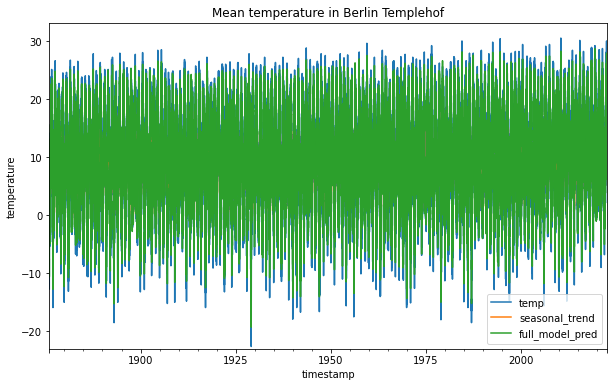

In [101]:
plot_meantemp(data)

In [102]:
X_test.head(1)

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
timestamp,,,,,,,,,,,,
2021-10-01,53234,0,0,0,0,0,0,0,0,1,0,0


In [103]:
print(f"""
full model score = {m_full.score(X_full, df_test['temp'])}
seasonal trend score = {m_lr2.score(X_test, df_test['temp'])}
""")


full model score = 0.915088039844729
seasonal trend score = 0.766917334531837



### Predict the future

In [104]:
df_test.head()

,temp,timestep,month,month_2,month_3,month_4,month_5,month_6,month_7,month_8,...,month_10,month_11,month_12,seasonal_trend,remainder,lag1,lag2,lag3,lag4,full_model_pred
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-10-01,12.7,53234,10,0,0,0,0,0,0,0,...,1,0,0,10.354001,2.345999,NaN,NaN,NaN,NaN,7.312649
2021-10-02,14.8,53235,10,0,0,0,0,0,0,0,...,1,0,0,10.354033,4.445967,2.345999,NaN,NaN,NaN,13.129893
2021-10-03,18.1,53236,10,0,0,0,0,0,0,0,...,1,0,0,10.354066,7.745934,4.445967,2.345999,NaN,NaN,13.747982
2021-10-04,14.8,53237,10,0,0,0,0,0,0,0,...,1,0,0,10.354099,4.445901,7.745934,4.445967,2.345999,NaN,16.663686
2021-10-05,13.1,53238,10,0,0,0,0,0,0,0,...,1,0,0,10.354132,2.745868,4.445901,7.745934,4.445967,2.345999,13.209385


In [105]:
# Combine train and test data
df_combined = df_train.append(df_test)
df_combined.head()

,temp,timestep,month,month_2,month_3,month_4,month_5,month_6,month_7,month_8,...,seasonal_trend,remainder,lag1,lag2,lag3,lag4,ar_prediction,full_pred_ar,arima_prediction,full_model_pred
timestamp,,,,,,,,,,,,,,,,,,,,,
1876-01-09,-12.7,8,1,0,0,0,0,0,0,0,...,-0.873048,-11.826952,-8.026919,-5.726886,-6.826854,-8.926821,-6.788354,-7.661402,0.000360,-7.632276
1876-01-10,-8.9,9,1,0,0,0,0,0,0,0,...,-0.873015,-8.026985,-11.826952,-8.026919,-5.726886,-6.826854,-9.741447,-10.614462,-9.502411,-10.584756
1876-01-11,-6.2,10,1,0,0,0,0,0,0,0,...,-0.872983,-5.327017,-8.026985,-11.826952,-8.026919,-5.726886,-5.621874,-6.494856,-5.660846,-6.465384
1876-01-12,-4.6,11,1,0,0,0,0,0,0,0,...,-0.872950,-3.727050,-5.327017,-8.026985,-11.826952,-8.026919,-4.119098,-4.992048,-3.873144,-4.962997
1876-01-13,-3.5,12,1,0,0,0,0,0,0,0,...,-0.872917,-2.627083,-3.727050,-5.327017,-8.026985,-11.826952,-3.027639,-3.900556,-2.726110,-3.872317


In [106]:
# Re-train the model on the whole dataset
X_combined = df_combined.drop(columns=['temp', 'seasonal_trend', 'remainder', 'month', 'ar_prediction','full_pred_ar','arima_prediction','full_model_pred'])
y_combined = df_combined['temp']

In [107]:
X_combined.loc['2021-10-01', 'lag1'] = df_train.loc['2021-09-30', 'remainder']
X_combined.loc['2021-10-01', 'lag2'] = df_train.loc['2021-09-29', 'remainder'] 
X_combined.loc['2021-10-01', 'lag3'] = df_train.loc['2021-09-28', 'remainder'] 
X_combined.loc['2021-10-01', 'lag4'] = df_train.loc['2021-09-27', 'remainder']
X_combined.loc['2021-10-02', 'lag2'] = df_train.loc['2021-09-30', 'remainder']
X_combined.loc['2021-10-02', 'lag3'] = df_train.loc['2021-09-29', 'remainder']
X_combined.loc['2021-10-02', 'lag4'] = df_train.loc['2021-09-28', 'remainder'] 
X_combined.loc['2021-10-03', 'lag3'] = df_train.loc['2021-09-30', 'remainder'] 
X_combined.loc['2021-10-03', 'lag4'] = df_train.loc['2021-09-29', 'remainder']
X_combined.loc['2021-10-04', 'lag4'] = df_train.loc['2021-09-30', 'remainder'] 

In [108]:
X_combined.tail()

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4
timestamp,,,,,,,,,,,,,,,,
2022-09-26,53594,0,0,0,0,0,0,0,1,0,0,0,-1.082690,-2.782658,-3.982625,-4.282592
2022-09-27,53595,0,0,0,0,0,0,0,1,0,0,0,-1.782723,-1.082690,-2.782658,-3.982625
2022-09-28,53596,0,0,0,0,0,0,0,1,0,0,0,-4.182756,-1.782723,-1.082690,-2.782658
2022-09-29,53597,0,0,0,0,0,0,0,1,0,0,0,-5.982788,-4.182756,-1.782723,-1.082690
2022-09-30,53598,0,0,0,0,0,0,0,1,0,0,0,-5.782821,-5.982788,-4.182756,-1.782723


In [109]:
m_combined = LinearRegression()
m_combined.fit(X_combined, y_combined)

LinearRegression()

In [110]:
m_combined.coef_

array([ 3.28837284e-05,  9.58780718e-01,  4.18402642e+00,  8.82352610e+00,
        1.39063108e+01,  1.72653392e+01,  1.89864353e+01,  1.82069941e+01,
        1.44547520e+01,  9.44079611e+00,  4.55809078e+00,  1.34561537e+00,
        9.19303749e-01, -1.94157186e-01,  5.48108392e-02,  1.66582617e-02])

### Prediction1

In [111]:
# prediction for 2022-10-01
#df_combined.index.max()
timestep = df_combined['timestep'].max() + 1
months = [0]*8 + [1] + [0]*2  # October 
lag1 = df_combined.loc['2021-09-30', 'remainder']
lag2 = df_combined.loc['2021-09-29', 'remainder']
lag3 = df_combined.loc['2021-09-28', 'remainder']
lag4 = df_combined.loc['2021-09-27', 'remainder']
print(timestep, months, lag1,lag2,lag3,lag4)

53599 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0] -3.6709068457876306 -1.4708741140134691 0.3291586177606902 2.6291913495348513


In [112]:
X_future = [timestep]
X_future.extend(months)
X_future.append(lag1)
X_future.append(lag2)
X_future.append(lag3)
X_future.append(lag4)
print(X_future)

[53599, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, -3.6709068457876306, -1.4708741140134691, 0.3291586177606902, 2.6291913495348513]


In [113]:
X_future = pd.DataFrame([X_future])
X_future.columns = X_combined.columns

X_future

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4
0,53599,0,0,0,0,0,0,0,0,1,0,0,-3.670907,-1.470874,0.329159,2.629191


In [114]:
# Prediction for 2022-10-01
# m_full.predict(X_future) 
m_combined.predict(X_future)

array([7.33122936])

In [115]:
print("Prediction for 2022-10-01 is {}".format(m_combined.predict(X_future)[0]))

Prediction for 2022-10-01 is 7.331229358309843


#### Prediction2

In [116]:
# prediction for 2022-11-01 
timestep = df_combined['timestep'].max() + 2
months = [0]*9 + [1] + [0]*1  # November
lag1 = 0
lag2 = 0
lag3 = 0
lag4 = 0

In [117]:
X_future_2 = pd.DataFrame([[timestep] + months + [lag1] + [lag2] + [lag3] + [lag4]])
X_future_2.columns = X_combined.columns
X_future_2

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4
0,53600,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [118]:
# Prediction for 2022-11-01
m_combined.predict(X_future_2)

array([5.47581534])